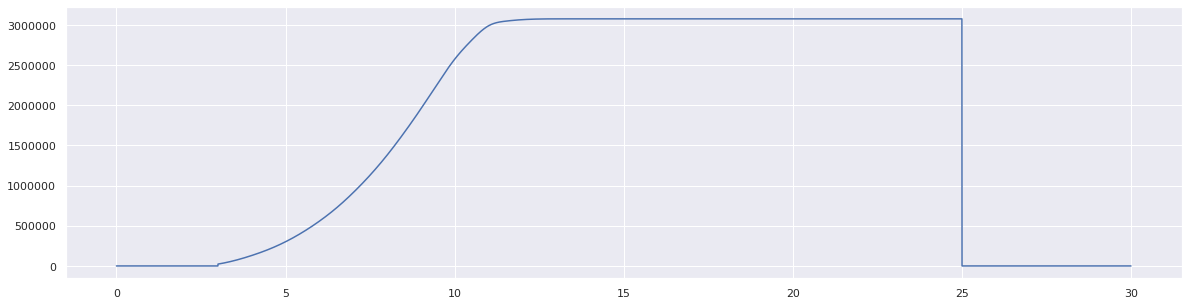

In [40]:
import pandas as pd
import numpy as np
import math
from scipy.stats import weibull_min, invweibull, uniform, norm
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

from pylab import rcParams

import seaborn as sns
sns.set()

rcParams['figure.figsize'] = 20,5

# Create the P function from matlab
data = np.loadtxt("powermat.csv", delimiter=",")
x = np.arange(0,30,0.001)
P = interp1d(x,data, fill_value="extrapolate")

# Creating lambda function allowing faster calculations
calculate_power = lambda x: P(x)
_ = plt.plot(x,P(x))

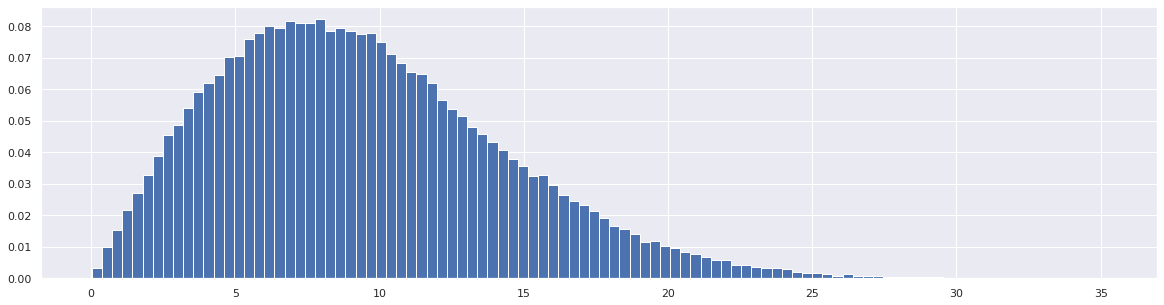

In [41]:
# Setting the parameters, this is for january
param = {
    "jan" : [10.6, 2.0],
    "feb" : [9.7, 2.0],
    "mar" : [9.2, 2.0],
    "apr" : [8.0, 1.9],
    "may" : [7.8, 1.9],
    "jun" : [8.1, 1.9],
    "jul" : [7.8, 1.9],
    "aug" : [8.1, 1.9],
    "sep" : [9.1, 2.0],
    "oct" : [9.9, 1.9],
    "nov" : [10.6, 2.0],
    "dec" : [10.6, 2.0]
}
[lam, k] = param["jan"]
n = 10**5

# Creating the wind distribution for a month
wind_distribution =  weibull_min(k,loc=0, scale=lam)

# Generate wind
wind = wind_distribution.rvs(size=n)
_ = plt.hist(wind, bins=100, density=True)

Mean: 1729909.3258311725 ± 7570.753199202632, Var: 1491990420742.318


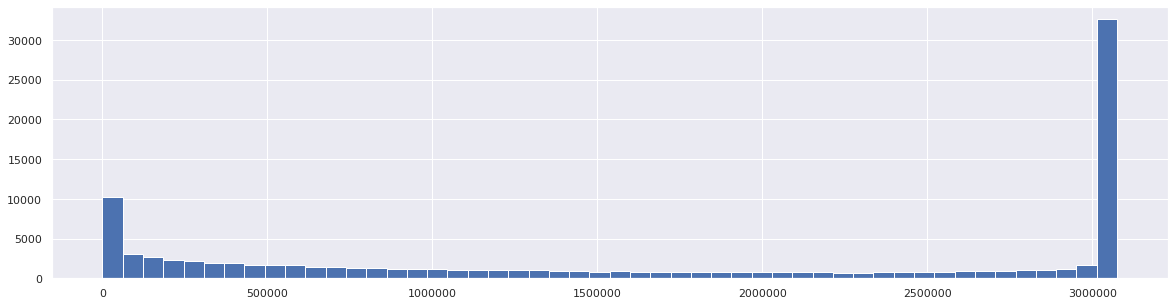

In [42]:
# A) Expected amount of power

# Calculated power from the generated wind
power = P(wind)
hist = plt.hist(power, bins=50)

# Calculating mean, variance and the confidence interval for the mean
mean = np.mean(power)
var = np.var(power)
confidence_interval = 1.96*np.sqrt(var/n)

print(f'Mean: {mean} ± {confidence_interval}, Var: {var}')

Mean: 1734618.6560271983 ± 6607.175477904739, Var: 1136369424089.5906


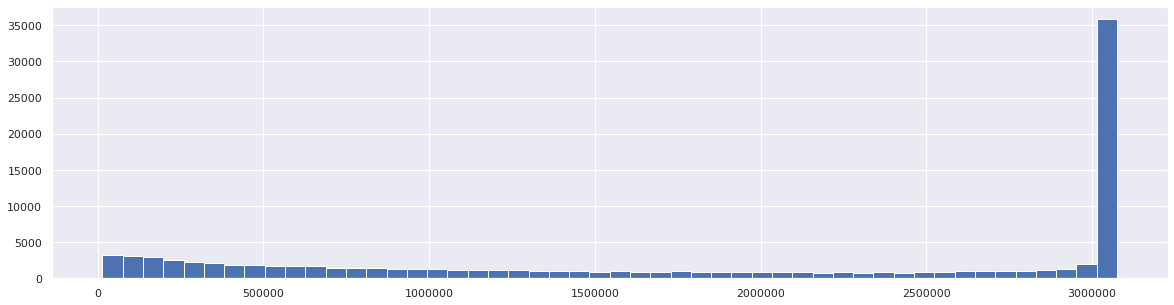

In [43]:
# A) Expected amount of power, truncated version

# Calculating F(3) and F(25) for the distribution for the wind
F_min = wind_distribution.cdf(3)
F_max = wind_distribution.cdf(25)

# Generate uniform data
u = uniform.rvs(size=n)

# Fix condition to U
u = ((F_max-F_min)*u + F_min)

# Run u through inverse of weibull 
wind_truncated = wind_distribution.ppf(u)

# Calculated the power for the truncated wind
power_trunc = calculate_power(wind_truncated)
hist = plt.hist(power_trunc, bins=50)

# Calculating mean, variance and the confidence interval for the mean
mean = np.mean(power_trunc)*(F_max-F_min)
var = np.var(power_trunc)*((F_max-F_min)**2)
confidence_intervall = 1.96*np.sqrt(var/n)

print(f'Mean: {mean} ± {confidence_intervall}, Var: {var}')

Mean: 1732125.9261512943 ± 2938.580032197696, Var: 224782710475.6094


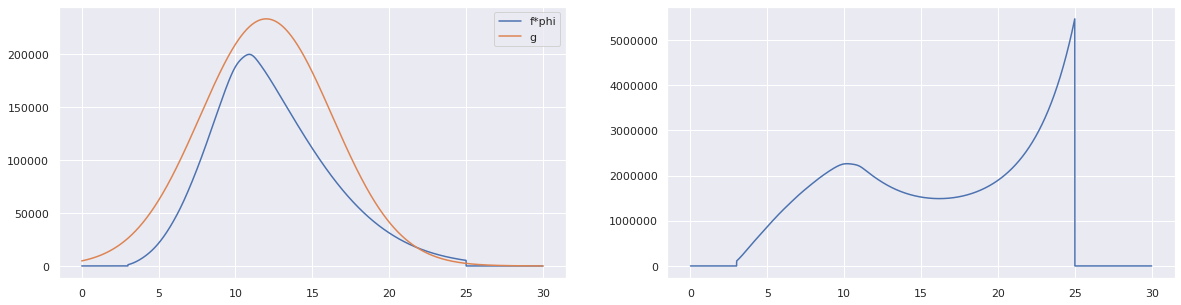

In [44]:
x = np.linspace(0,30, num=n)


h = lambda x: P(x)*wind_distribution.pdf(x)

# Selecting g as a normal distribution
my = 12
sigma2 = 4.3
g_scale = 10**6.4
g_dist = norm(my, sigma2)
g = lambda x: g_dist.pdf(x)

plt.subplot(1,2,1)

plt.plot(x,h(x), label='f*phi')
plt.plot(x, g_scale*g(x), label = 'g')
plt.legend()

plt.subplot(1,2,2)

plt.plot(x, h(x)/g(x))

X = g_dist.rvs(size=n)

# Function to evaluate
s = lambda x: h(x)/g(x)

# Calculate variance
mean = np.mean(s(X))
var = np.var(s(X))
confidence_interval = 1.96*np.sqrt(var/n)

print(f'Mean: {mean} ± {confidence_interval}, Var: {var}')

1743413.085296709
1741678.1388730335
1961978831366.8782
1962690317669.6326
1742545.6120848712
Mean: 1747737.75 ± 5019.4650426119315, Var: 655847285349.9375


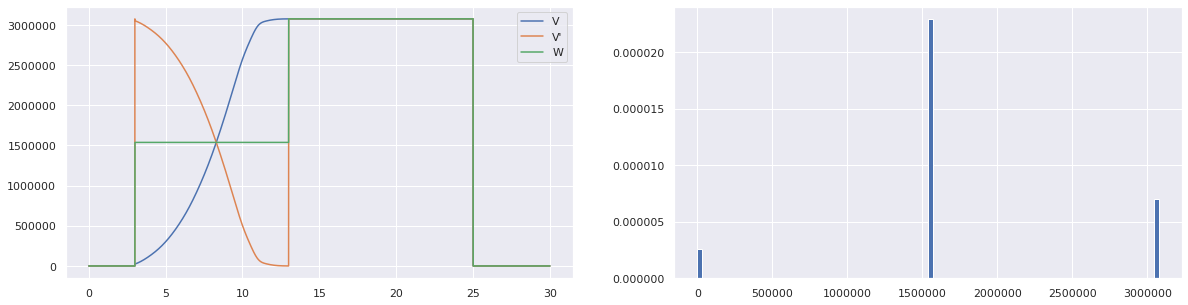

In [45]:
# Letting V = P, and V' = Max(P) - P, unsure if this has increased complexity
V_1 = P
V_2 = lambda x: np.where((x >= 3) & (x <= 13), -P(x) + P(13), P(x))
W = lambda x: (V_1(x) + V_2(x))/2

plt.subplot(1, 2, 1)

plt.plot(x, V_1(x), label = "V")
plt.plot(x, V_2(x), label = "V'")
plt.plot(x, W(x), label = "W")

plt.legend(loc='upper right')

plt.subplot(1, 2, 2)

print(np.mean(V_1(x)))
print(np.mean(V_2(x)))
print(np.var(V_1(x)))
print(np.var(V_2(x)))
print(np.mean(W(x)))

power_as = W(wind)
hist = plt.hist(power_as, density=True, bins=100)

# Calculating mean, variance and the confidence interval for the mean
mean = np.mean(power_as)
var = np.var(power_as)
confidence_intervall = 1.96*np.sqrt(var/n)

print(f'Mean: {mean} ± {confidence_intervall}, Var: {var}')

In [46]:
# Probability that the turbine delivers power
print(f'Prob for delivering power: {(F_max - F_min)*100}%')

Prob for delivering power: 91.91850832071029%


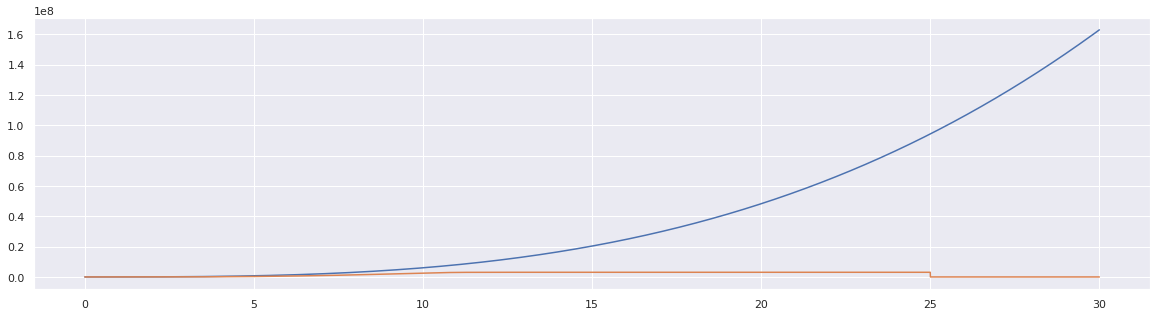

In [47]:
Ptot = lambda v: 1/2*1.225*math.pi*112**2/4*v**3

plt.plot(x,Ptot(x))
plt.plot(x,P(x))

Mean: 1730341.8169260102 ± 2955.5516032590704, Var: 227386643053.08365


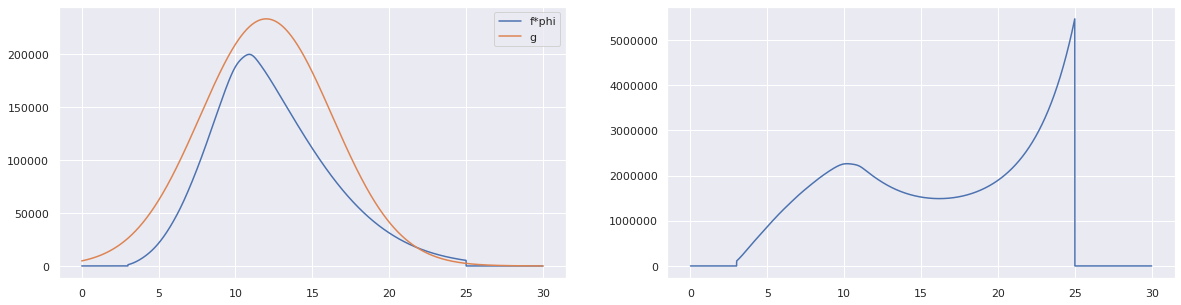

In [48]:
with np.errstate(divide='ignore', invalid='ignore'):
    _ = plt.plot(x, P(x)/Ptot(x))

x = np.linspace(0,30, num=n)

power_ratio = P(x)/Ptot(x)

h = lambda x: P(x)*wind_distribution.pdf(x)

# Selecting g as a normal distribution
my = 12
sigma2 = 4.3
g_scale = 10**6.4
g_dist = norm(my, sigma2)
g = lambda x: g_dist.pdf(x)

plt.subplot(1,2,1)

plt.plot(x,h(x), label='f*phi')
plt.plot(x, g_scale*g(x), label = 'g')
plt.legend()

plt.subplot(1,2,2)

plt.plot(x, h(x)/g(x))

X = g_dist.rvs(size=n)

# Function to evaluate
s = lambda x: h(x)/g(x)

# Calculate variance
mean = np.mean(s(X))
var = np.var(s(X))
confidence_interval = 1.96*np.sqrt(var/n)

print(f'Mean: {mean} ± {confidence_interval}, Var: {var}')

In [ ]:
# Antar att man ska sampla från Power curve?